In [15]:
import sys 
sys.path.append("..") 

#from topological_models import generator
import numpy as np
import numpy.linalg as LA

from topology_model import NonHermitianHamiltonian, NonHermitianTopologicalModel
import matplotlib.pyplot as plt
from machine_learning import Cluster
from machine_learning import Classifier
from topology_model import sigma_0, sigma_x, sigma_y, sigma_z
from topology_model import Generator
from topology_model import topology_comparator, topology_verifier, obtain_phase_center_and_number

In [17]:
class Mobius2D(NonHermitianHamiltonian):
    def __init__(self, E_ref=0.):
        super().__init__(E_ref)
        self.parameters = list()
        self.initiate()

    def get_n(self):
        '''
        n*n Hamiltonian
        '''
        return 4

    def get_n_dim(self):
        return 2

    def get_parameters(self):
        return self.parameters

    def set_parameters(self, **kwargs):
        self.parameters = kwargs['t1'], kwargs['t2'], kwargs['gamma'], kwargs['kappa']

    def get_kpoints(self):
        n_points = 3
        kpoints = list()
        for kx in np.linspace(-np.pi,np.pi,n_points):
            for ky in np.linspace(-np.pi,np.pi,n_points):
                kpoints.append([kx, ky])
        return kpoints

    def initiate(self):
        t2 = 1.
        kappa = 0.25
        t1 = 2*np.random.random()
        gamma = 2*np.random.random()
        #gamma = 0.
        self.parameters = t1, t2, gamma, kappa

    def is_real_line_gap(self):
        for k in self.get_kpoints():
            hk = self.get_Hamiltonian(k)
            Es = LA.eigvals(hk)
            #print(np.abs(np.real(Es)))
            if np.any(np.abs(np.real(Es - self.E_ref)) < 1e-3):
                return False
        return True  

    def get_Hamiltonian(self, k):
        kx, ky= k
        t1, t2, gamma, kappa = self.parameters
        deltat = 1e-10
        
        hk = np.array([
            [0, t1+gamma/2+t2*np.exp(-1j*ky), kappa+kappa*np.exp(-1j*kx), 0],
            [t1-gamma/2+t2*np.exp(1j*ky), 0, 0, kappa+kappa*np.exp(-1j*kx)],
            [kappa+kappa*np.exp(1j*kx), 0, 0, -(deltat + t1+gamma/2+t2*np.exp(-1j*ky))],
            [0, kappa+kappa*np.exp(1j*kx), -(deltat + t1-gamma/2+t2*np.exp(1j*ky)), 0]
        ])

        hk = hk - self.E_ref*np.identity(4)
        
        return hk
    
class Mobius2DPerturbation(NonHermitianHamiltonian):
    def __init__(self, E_ref=0.):
        super().__init__(E_ref)
        self.parameters = list()
        self.initiate()

    def get_n(self):
        '''
        n*n Hamiltonian
        '''
        return 4

    def get_n_dim(self):
        return 2

    def get_parameters(self):
        return self.parameters

    def set_parameters(self, **kwargs):
        self.parameters = kwargs['t1'], kwargs['t2'], kwargs['kappa']

    def get_kpoints(self):
        n_points = 3
        kpoints = list()
        for kx in np.linspace(-np.pi,np.pi,n_points):
            for ky in np.linspace(-np.pi,np.pi,n_points):
                kpoints.append([kx, ky])
        return kpoints

    def initiate(self):
        t2 = 1.
        kappa = 0.25
        t1 = 2*np.random.random()
        #gamma = 3*np.random.random()
        self.parameters = t1, t2, kappa

    def is_real_line_gap(self):
        return True  

    def get_Hamiltonian(self, k):
        kx, ky= k
        t1, t2, kappa = self.parameters
        
        hk = np.array([
            [0, t1+t2*np.exp(-1j*ky), kappa+kappa*np.exp(-1j*kx), 0],
            [t1+t2*np.exp(1j*ky), 0, 0, kappa+kappa*np.exp(-1j*kx)],
            [kappa+kappa*np.exp(1j*kx), 0, 0, -(t1+t2*np.exp(-1j*ky))],
            [0, kappa+kappa*np.exp(1j*kx), -(t1+t2*np.exp(1j*ky)), 0]
        ])

        hk = hk - self.E_ref*np.identity(4)
        
        return 0.1*hk

In [18]:
#name = "Chern2D"
gap_type="real line"
E_ref = 0.
hamiltonian_model = Mobius2D(E_ref=E_ref)
generator = Generator(hamiltonian=hamiltonian_model, gap_type=gap_type)

n_sample = 500
_models, vs = generator.generate_models(n_sample)
#Qs, vs = generator.generate(n_sample)
n = generator.get_n()

models = list()
for model in _models:
    if model.is_real_line_gap():
        models.append(model)

print("Number of samples: ", len(models))

Number of samples:  240


In [ ]:
# for imodel, model in enumerate(models):
#     hk = model.get_Hamiltonian([0,0])
#     values, Rvectors = LA.eig(hk)
#     _, Lvectors = LA.eig(np.conjugate(np.transpose(hk)))

#     Rvectors = np.transpose(Rvectors)
#     Lvectors = np.transpose(Lvectors)

#     indices = np.zeros(len(values), dtype=int)
#     for iv, rvector in enumerate(Rvectors):
#         _coeffs = np.zeros(len(values), dtype=complex)
#         for jv, lvector in enumerate(Lvectors):
#             _coeffs[jv] = np.conjugate(lvector).dot(rvector)

#         #print(iv
#         #print(np.around(np.abs(_coeffs),decimals=3))
#         indices[iv] = int(np.argmax(np.abs(_coeffs)))

#     if len(np.unique(indices)) != len(values):
#         print(indices)
#         print(imodel)
#         print(model.get_parameters())
#         raise Exception("Error in calculating the eigenvectors")

In [19]:
cluster = Cluster(similarity_function=topology_comparator, verbose=False)
center_indices, group_number = cluster.fit(models)
print(group_number)
print("The number of centers: ", len(center_indices))

[124 116]
The number of centers:  2


In [20]:
print("Gap type: ", gap_type)
hamiltonian_perturbation = Mobius2DPerturbation(E_ref=E_ref)
generator = Generator(hamiltonian=hamiltonian_perturbation, gap_type=gap_type)

n_sample = 10
perturbations, vs = generator.generate_models(n_sample)
#Qs, vs = generator.generate(n_sample)
n = generator.get_n()

new_center_indices, new_group_number = obtain_phase_center_and_number(center_indices, group_number, models, perturbations)
print("The number of phases: ", len(new_group_number))
print(new_group_number)

Gap type:  real line
The number of phases:  2
[124, 116]


In [21]:
for model in [models[index] for index in new_center_indices]:
    print(model.get_parameters())

(1.56530598843555, 1.0, 0.4664380302469666, 0.25)
(0.24840281254186625, 1.0, 1.282689882863022, 0.25)


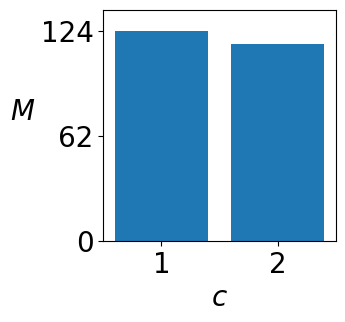

In [22]:
plt.figure(figsize=(3,3))
plt.bar(np.arange(len(new_group_number))+1, new_group_number)
plt.xlim([0.5,len(new_group_number)+0.5])
plt.xticks(list(range(1,len(new_group_number)+1)),fontsize=20)
plt.ylim([0, np.max(new_group_number)*1.1])
plt.yticks([0, int(np.max(new_group_number)/2), int(np.max(new_group_number))],fontsize=20)
plt.xlabel(r"$c$",fontsize=20)
plt.ylabel(r"$M$",fontsize=20,rotation=0,horizontalalignment='right')
plt.show()

# Phase diagram

In [23]:
classifier = Classifier(similarity_func=topology_comparator, cluster_centers=[models[index] for index in new_center_indices])
n1 = 51
n2 = 51
t1s = np.linspace(0.0001,2,n1)
gammas = np.linspace(0.001,2.,n2)
v_list = np.zeros((n1,n2))

print(gap_type)

for i in range(n1):
    for j in range(n2):
        hamiltonian = Mobius2D(E_ref=0.)
        hamiltonian.set_parameters(t1=t1s[i], t2=1., gamma=gammas[j], kappa=1.)
        if hamiltonian.is_real_line_gap():
            _model = NonHermitianTopologicalModel(hamiltonian=hamiltonian, gap_type="real line")
            #v_list.append(1)
            v_list[i,j] = classifier.classify(_model)
    print(i)

real line
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


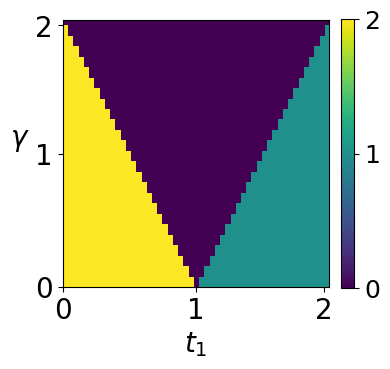

In [24]:
plt.figure(figsize=(4,4))
plt.imshow(np.transpose(v_list), origin='lower',extent = [0,n1,0,n2])
plt.xlabel(r"$t_1$",fontsize=20)
plt.ylabel(r"$\gamma$",fontsize=20,rotation=0,horizontalalignment='right')
plt.xticks([0, n1/2, n1-1],[r"0", "1", r"2"],fontsize=20)
plt.yticks([0, n2/2, n2-1],[r"0", "1", r"2"], fontsize=20)

cb = plt.colorbar(ticks=range(len(center_indices)+1), fraction=0.046, pad=0.04)
cb.ax.tick_params(labelsize=18)
plt.tight_layout()
plt.show()

# Save data

In [25]:
from tools import save_data, save_data_M

name = "2D_Mobius_real"
save_data(new_center_indices, new_group_number, "fig3_{0}_group_number.h5".format(name))
save_data_M(v_list, "fig3_{0}_phase_diagram.h5".format(name))
print(name)

2D_Mobius_real
